# COMPUTE THE DURATION OF A PROJECT
# A. in a deterministich way (Critical path method)
# B. taking into account uncertainty using PERT
# C. taking into account uncertainty using MC simulations 
#
# 
# by Fulvio Re Cecconi
# this code is provided under the Creative Commons CC BY license 
# https://creativecommons.org/licenses/by/4.0/

In [1]:
# import needed libraries
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import math
from collections import Counter
from scipy.stats import norm

## Deterministic

In [2]:
graph_data = pd.DataFrame([['A','B',4],
                           ['A','C',4], 
                           ['B','D',4], 
                           ['C','D',2], 
                           ['D','E',3]])
graph_data.columns = ['source', 'target', 'duration']
graph_data.head()

,source,target,duration
0,A,B,4
1,A,C,4
2,B,D,4
3,C,D,2
4,D,E,3


In [3]:
# Create a directed graph from the DataFrame.
# The 'duration' column is added as an edge attribute.
my_graph = nx.from_pandas_edgelist(
    graph_data,
    source='source',
    target='target',
    edge_attr='duration',  # This will be stored as 'duration'
    create_using=nx.DiGraph()
)

# If you prefer to have the edge weight under the key 'weight'
for u, v, attr in my_graph.edges(data=True):
    attr['weight'] = attr.pop('duration')

# Optionally, verify that the graph is acyclic (a DAG)
if nx.is_directed_acyclic_graph(my_graph):
    print("The graph is a directed acyclic graph (DAG).")
else:
    print("Warning: The graph contains cycles and is not a DAG.")

# You can now use G for further analysis, e.g., topological sorting:
try:
    topo_order = list(nx.topological_sort(my_graph))
    print("Topological ordering of nodes:", topo_order)
except nx.NetworkXUnfeasible:
    print("Graph contains cycles; topological sort is not possible.")

The graph is a directed acyclic graph (DAG).
Topological ordering of nodes: ['A', 'B', 'C', 'D', 'E']


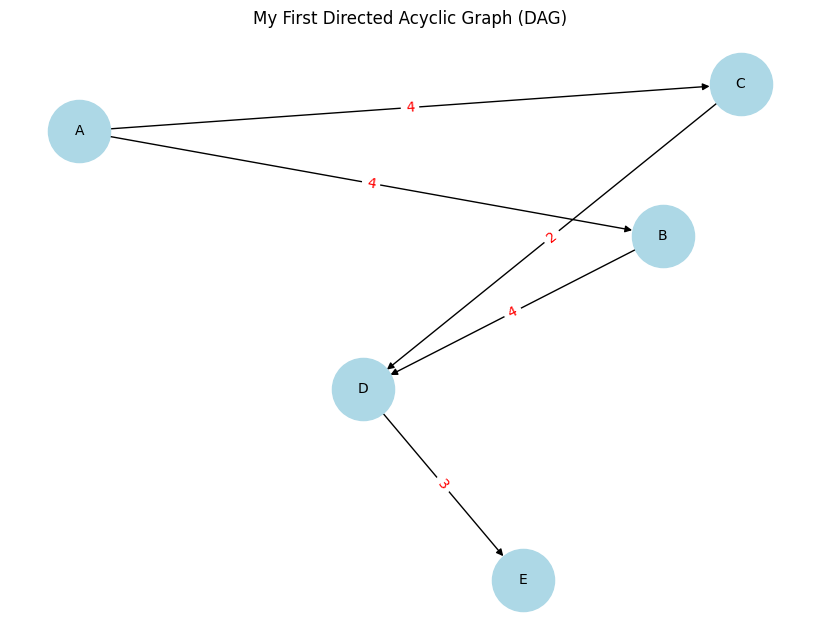

In [4]:
# Plot the graph with node names as labels.
plt.figure(figsize=(8, 6))
# Compute a layout for visualization.
pos = nx.spring_layout(my_graph)

# Draw nodes, edges, and labels.
nx.draw(my_graph, pos, with_labels=True, node_color='lightblue', arrows=True, node_size=2000, font_size=10)

# Optionally, add edge labels to show weights (duration values)
edge_labels = nx.get_edge_attributes(my_graph, 'weight')
nx.draw_networkx_edge_labels(my_graph, pos, edge_labels=edge_labels, font_color='red')

plt.title("My First Directed Acyclic Graph (DAG)")
plt.show()

In [5]:
# print all the paths

# Identify source nodes (nodes with no incoming edges)
sources = [node for node in my_graph.nodes() if my_graph.in_degree(node) == 0]

# Identify sink nodes (nodes with no outgoing edges)
sinks = [node for node in my_graph.nodes() if my_graph.out_degree(node) == 0]

# Iterate over each source and sink combination and print all simple paths
for source in sources:
    for sink in sinks:
        print(f"Paths from {source} to {sink}:")
        for path in nx.all_simple_paths(my_graph, source=source, target=sink):
            print(path)

Paths from A to E:
['A', 'B', 'D', 'E']
['A', 'C', 'D', 'E']


In [6]:
# print the longest path

longest_path = nx.algorithms.dag.dag_longest_path(my_graph, weight='weight')
print("Longest path:", longest_path)

Longest path: ['A', 'B', 'D', 'E']


In [7]:
# compute the longest path duration
print('deterministic project duration is',nx.dag_longest_path_length(my_graph),'months')

deterministic project duration is 11 months


## PERT

In [8]:
# define uncertainty in input
uncertainty = pd.DataFrame([[3,4,5],
                            [2,4,6],
                            [3,4,5],
                            [1,2,3],
                            [1,3,5]])
uncertainty.columns = ['min_value', 'mode', 'max_value']
uncertainty.head()

,min_value,mode,max_value
0,3,4,5
1,2,4,6
2,3,4,5
3,1,2,3
4,1,3,5


In [9]:
# compute media duration
median_duration = (uncertainty['min_value'] + 4 * uncertainty['mode'] + uncertainty['max_value']) / 6
print(median_duration)

0    4.0
1    4.0
2    4.0
3    2.0
4    3.0
dtype: float64


In [10]:
# compute standard deviation
std_duration = (uncertainty['max_value'] - uncertainty['min_value']) / 6
print(std_duration)

0    0.333333
1    0.666667
2    0.333333
3    0.333333
4    0.666667
dtype: float64


In [11]:
# create a new graph from my_graph using the media duration
pert_graph = my_graph.copy()

# Update each edge with the corresponding duration
for i, (u, v, data) in enumerate(pert_graph.edges(data=True)):
    data['duration'] = median_duration[i]

# (Print each edge and its updated duration for verification
for u, v, data in pert_graph.edges(data=True):
    print(f"Edge from {u} to {v} has duration: {data['duration']}")

Edge from A to B has duration: 4.0
Edge from A to C has duration: 4.0
Edge from B to D has duration: 4.0
Edge from C to D has duration: 2.0
Edge from D to E has duration: 3.0


In [12]:
# print the longest path
longest_path = nx.algorithms.dag.dag_longest_path(my_graph, weight='weight')
print("Longest path:", longest_path)

# compute the longest path duration
total_median_duration = nx.dag_longest_path_length(pert_graph)
print('project duration computed with median is',total_median_duration,'months')

Longest path: ['A', 'B', 'D', 'E']
project duration computed with median is 11 months


In [13]:
# compute Z starting from a given contractual project duration
contractual_duration = 12

# square root of the sum the sqaure of the standard deviation of the activities on the critical path
square_std = np.sqrt((std_duration[0])**2+(std_duration[2])**2+(std_duration[4])**2)

# compute random Z
random_z = (contractual_duration - total_median_duration) / square_std
print('random variable Z:', random_z)

random variable Z: 1.224744871391589


In [18]:

# compute the probability of finishing befor the contractual duration
# Compute the cumulative Gaussian using scipy
p =  norm.cdf(random_z)

print(f'probability of meeting the contractual timeframe: {p*100:.2f}%')


probability of meeting the contractual timeframe: 88.97%


# MC simulations

In [19]:
# define uncertainty in input
uncertainty = pd.DataFrame([[3,4,5],
                            [2,4,6],
                            [3,4,5],
                            [1,2,3],
                            [1,3,5]])
uncertainty.columns = ['min_value', 'mode', 'max_value']
uncertainty.head()

,min_value,mode,max_value
0,3,4,5
1,2,4,6
2,3,4,5
3,1,2,3
4,1,3,5


In [20]:
# check that my_grapf and duration has the same length
if my_graph.number_of_edges() == len(uncertainty):
    print('same length')
else: print('check lengths')

same length


In [21]:
edges = my_graph.edges

# Number of simulation iterations
num_simulations = 1000
simulation_results = []
longest_paths = []

# Monte Carlo simulation
for i in range(num_simulations):
    # For each simulation, sample a duration for each edge
    for idx, (u, v) in enumerate(edges):
        # Extract the triangular distribution parameters from the uncertainty DataFrame
        a = uncertainty.iloc[idx, 0]  # minimum value
        c = uncertainty.iloc[idx, 1]  # mode (peak)
        b = uncertainty.iloc[idx, 2]  # maximum value
        
        # Sample the duration from the triangular distribution
        duration = np.random.triangular(a, c, b)
        
        # Update the graph's edge attribute with the sampled duration
        my_graph[u][v]['duration'] = duration
    
    # Compute the longest (critical) path in the DAG
    # nx.algorithms.dag.dag_longest_path returns the nodes along the longest path
    longest_path = nx.algorithms.dag.dag_longest_path(my_graph, weight='duration')
    longest_paths.append(longest_path)  # Memorize the longest path
    
    # Sum the durations along the longest path
    total_duration = 0.0
    for j in range(len(longest_path) - 1):
        u, v = longest_path[j], longest_path[j + 1]
        total_duration += my_graph[u][v]['duration']
    
    simulation_results.append(total_duration)

# Analyze the simulation results
mean_duration = np.mean(simulation_results)
percentile_75 = np.percentile(simulation_results, 75)
percentile_90 = np.percentile(simulation_results, 90)

print("Mean project duration:", mean_duration)
print("75th percentile project duration:", percentile_75)
print("90th percentile project duration:", percentile_90)

Mean project duration: 11.048991718013376
75th percentile project duration: 11.752096329026081
90th percentile project duration: 12.300498348587682


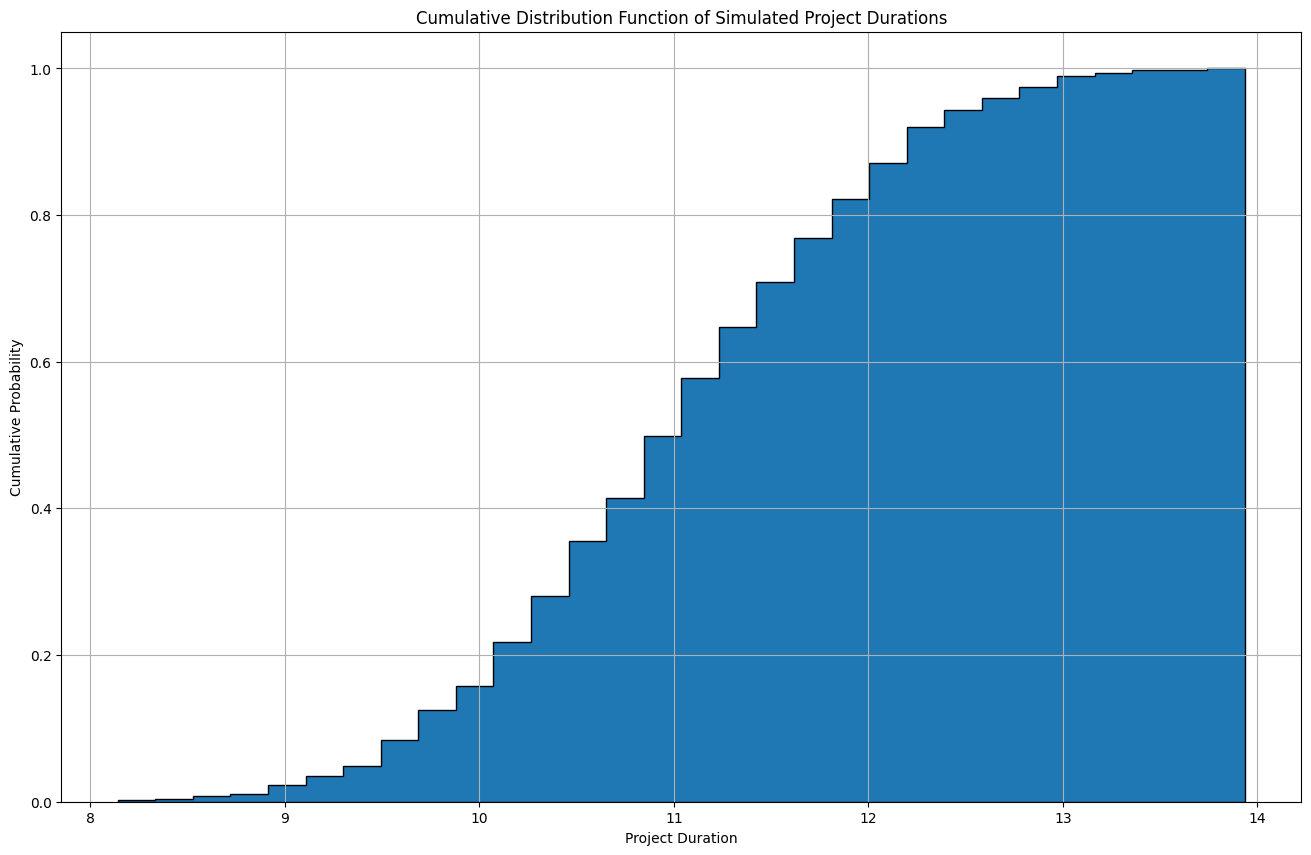

In [22]:
# plot the cumulative distribution of the duration of the project
plt.figure(figsize=(16,10))

plt.hist(simulation_results, bins=30, density=True, cumulative=True, edgecolor='black', histtype='stepfilled')
plt.xlabel("Project Duration")
plt.ylabel("Cumulative Probability")
plt.title("Cumulative Distribution Function of Simulated Project Durations")
plt.grid(True)
plt.show()

In [ ]:
# Convert the list to a NumPy array for element-wise operations
simulation_results = np.array(simulation_results)

# Perform element-wise comparison
mask = simulation_results < contractual_duration

print(f"Fraction of elements below {contractual_duration}: {np.mean(mask)*100:.1f}%")

Fraction of elements below 12: 82.0%


In [ ]:
# find the unique longest paths
unique_paths = set(tuple(path) for path in longest_paths)

# count how many times each longest path appears
unique_counts = Counter(tuple(path) for path in longest_paths)
print(unique_counts)

In [ ]:
# Create a bar chart
plt.figure(figsize=(5, 3))
plt.bar(range(len(unique_paths)), unique_counts.values())

# Set x-tick labels to display the unique paths (convert tuples to strings)
plt.xticks(range(len(unique_paths)), [str(path) for path in unique_paths], rotation=45, ha="right")

plt.xlabel("Longest Path")
plt.ylabel("Count")
plt.title("Frequency of Each Longest Path in MC Simulation")
plt.tight_layout()
plt.show()